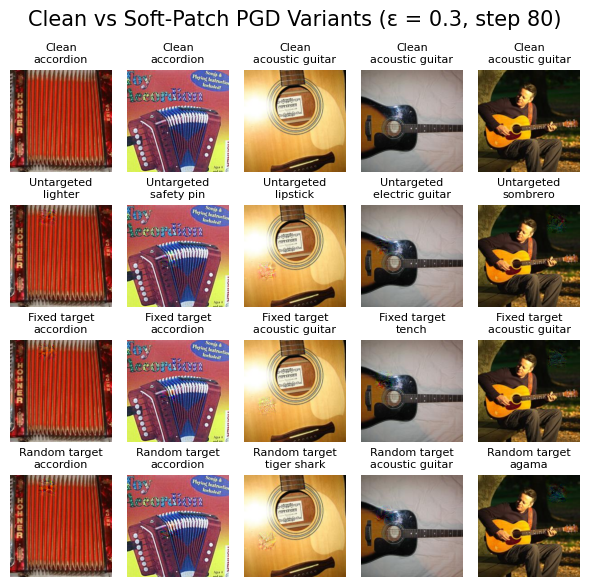

In [1]:
import os, json, torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets

# Path settings
DATASET_ROOT = "./TestDataSet"
ADV_UNTARGET = "adv_set_patch_soft_eps0.3_step80_untargeted.pt"
ADV_TARGET   = "adv_set_patch_soft_eps0.3_step80.pt"
ADV_RANDOM   = "adv_set_patch_soft_random_0.3_80.pt"
LABELS_JSON  = os.path.join(DATASET_ROOT, "labels_list.json")

# Normalization helpers
mean = np.array([0.485, 0.456, 0.406], np.float32)
std  = np.array([0.229, 0.224, 0.225], np.float32)
norm     = transforms.Normalize(mean.tolist(), std.tolist())
inv_norm = transforms.Normalize((-mean / std).tolist(), (1 / std).tolist())

# Load clean dataset
ds = datasets.ImageFolder(DATASET_ROOT, transform=transforms.Compose([
    transforms.ToTensor(), norm]))
loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)

with open(LABELS_JSON) as f:
    idx2true = {i: int(e.split(':', 1)[0]) for i, e in enumerate(json.load(f))}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

clean_imgs, clean_labels = [], []
for x, labs in loader:
    clean_imgs.append(x)
    clean_labels.append(torch.tensor([idx2true[int(l)] for l in labs]))
clean_imgs   = torch.cat(clean_imgs).to(device)
clean_labels = torch.cat(clean_labels).cpu()

# Load adversarial sets
adv_sets = {
    "Untargeted":    torch.load(ADV_UNTARGET)["images"].to(device),
    "Fixed target":  torch.load(ADV_TARGET)["images"].to(device),
    "Random target": torch.load(ADV_RANDOM)["images"].to(device),
}

# Prediction helper
@torch.no_grad()
def predict(tensor, batch=64):
    out = []
    for i in range(0, len(tensor), batch):
        logits = model(tensor[i:i+batch])
        out.extend(logits.argmax(1).cpu())
    return torch.tensor(out)

clean_pred = predict(clean_imgs)
adv_pred   = {k: predict(v) for k, v in adv_sets.items()}
true_lbl   = clean_labels
label_str  = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

# Select 5 examples where clean is correct but some adv is wrong
picked = []
for i in range(len(clean_imgs)):
    if clean_pred[i] == true_lbl[i] and any(adv_pred[k][i] != true_lbl[i] for k in adv_sets):
        picked.append(i)
    if len(picked) == 5:
        break

# Plot
rows = ["Clean"] + list(adv_sets.keys())
img_sets  = [clean_imgs] + [adv_sets[k] for k in adv_sets]
pred_sets = [clean_pred] + [adv_pred[k] for k in adv_sets]

fig, axes = plt.subplots(len(rows), len(picked), figsize=(6, 6))
for r, row_name in enumerate(rows):
    for c, idx in enumerate(picked):
        img = inv_norm(img_sets[r][idx].cpu()).permute(1, 2, 0).clamp(0, 1)
        axes[r, c].imshow(img)
        axes[r, c].set_axis_off()
        axes[r, c].set_title(f"{row_name}\n{label_str[pred_sets[r][idx]]}", fontsize=8)

plt.suptitle("Clean vs Soft‑Patch PGD Variants (ε = 0.3, step 80)", fontsize=15)
plt.tight_layout()
plt.savefig("patch_pgd_comparison.png", dpi=300, bbox_inches="tight")
plt.show()